In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import pywt

During this project, we will try to classify photographs of the following athletes:  
- Roger Federer, Swiss tennis player  
- Serena Williams, American tennis player   
- Maria Sharapova, Russian tennis player  
- Lionel Messi, Argentine international footballer  
- Virat Kohli, Indian international cricketer

This project was suggested to me by the DataScience training provided by Codebasics (https://codebasics.io/). The dataset comes from the Kaggle webscrapping and can be visualized in the images_dataset folder. 

This project covers the pre-processing of images to be classified, and the exploration of some simple classification models.

In this project, I have not yet used Deep Learning techniques, which would probably have been more effective (other projects will illustrate their use). The aim here was to compare a few simple Machine Learning models, which don't require too much computing power.

<h1 style="color:blue; font-weight:bold;"> Data Visualization </h1>

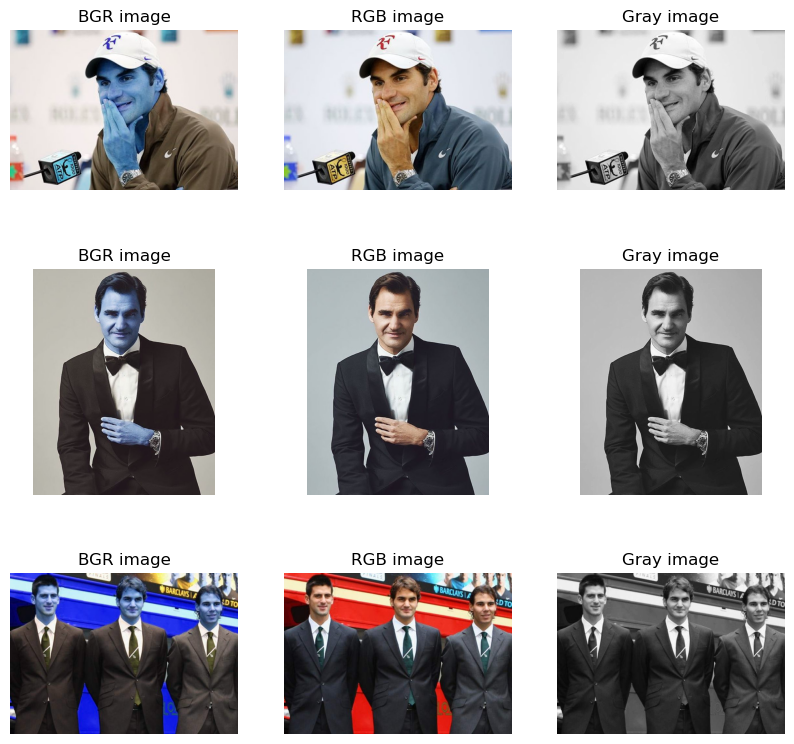

In [2]:
path_img_tests = [('./useful_images_in_notebook/federer'+str(i)+'.jpg') for i in range(1,4)]
plt.figure(figsize=(10,10))
for i in range(1,4):
    img_test = cv2.imread(path_img_tests[i-1])
    plt.subplot(3,3,3*(i-1) + 1), plt.imshow(img_test)
    plt.title('BGR image')
    plt.axis('off') 
    img_rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,3*(i-1) + 2), plt.imshow(img_rgb)
    plt.title('RGB image')
    plt.axis('off') 
    img_gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
    plt.subplot(3,3,3*(i-1) + 3), plt.imshow(img_gray, cmap = 'gray')
    plt.title('Gray image')
    plt.axis('off') 
plt.show()

That is the kind of image we can find in the dataset. These examples illustrate that faces can sometimes be slightly obscured, or that several people can appear in the same photo. By default, images are loaded in BGR encoding by cv2.imread.

<h1 style="color:blue; font-weight:bold;"> Data Visualization </h1>

First, we used Haar's algorithm to detect objects in an image. Here, we detected faces, then eyes. We made the empirical choice of retaining only those images where a face is detected, with at least one eye detected by the algorithm. The following code comes from the OpenCV Face detection documentation.

In [3]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

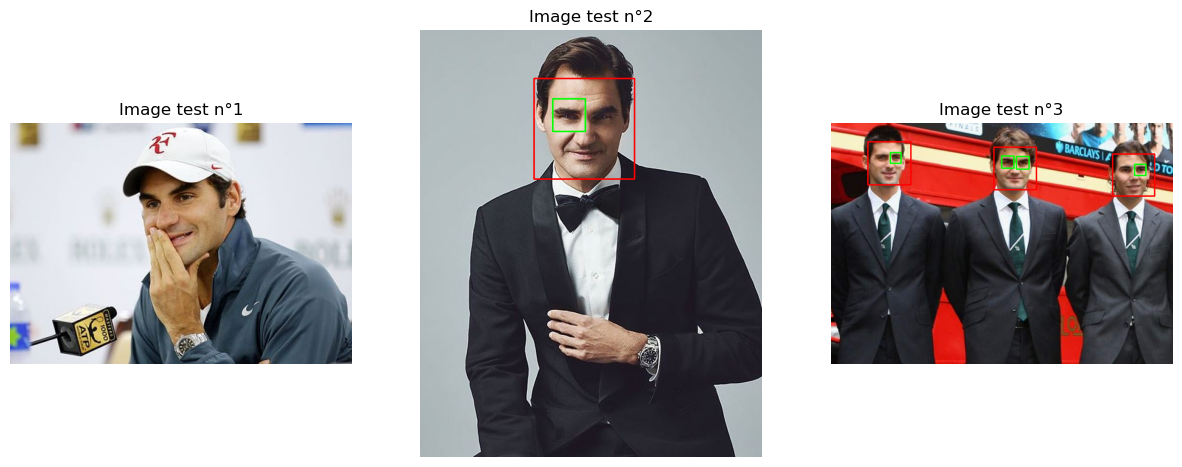

In [4]:
index_subplot=0
plt.figure(figsize=(15, 15))
## From OpenCV Face Detection documentation
for img_path in path_img_tests: 
    index_subplot += 1
    image = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face = face_cascade.detectMultiScale(img_gray, scaleFactor=1.2, minNeighbors=5)
    face_img = img_rgb.copy()
    for (x,y,w,h) in face:
        face_img = cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = img_gray[y:y+h, x:x+w]
        roi_rgb = face_img[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_rgb,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    plt.subplot(1,3,index_subplot), plt.imshow(face_img, cmap='gray')
    plt.axis('off')
    plt.title('Image test n°' + str(index_subplot))
plt.show()

Note that in the first photo, Federer's face is not detected because of his hand. This type of image will not be used in the rest of the project.  
Then, we will extract faces matching the requirements, and save them as individual images.

In [5]:
def crop_faces_from_full_image(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cropped_images = []
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.2, minNeighbors=5)
    if len(faces) == 0:
        return None
    for (x, y, w, h) in faces:
        roi_gray = img_gray[y:y+h, x:x+w]
        roi_color = img_rgb[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(roi_gray)
        if len(eyes) > 0:
            cropped_images.append(roi_color)
    if len(cropped_images) == 0:
        return None
    return cropped_images

def save_cropped_image(image, count, name):
    cropped_images = crop_faces_from_full_image(image)
    if cropped_images is None:
        return
    output_dir = f'./images_dataset/cropped/{name}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for index, face in enumerate(cropped_images):
        filename = os.path.join(output_dir, f'{count}_{index}.jpg')
        cv2.imwrite(filename, cv2.cvtColor(face, cv2.COLOR_RGB2BGR)) 

In [6]:
import shutil
path_cropped_data = './images_dataset/cropped/'
if os.path.exists(path_cropped_data):
    shutil.rmtree(path_cropped_data)
os.mkdir(path_cropped_data)

In [7]:
import os
img_dirs = []
for entry in os.scandir('./images_dataset/'):
    if entry.is_dir():
        if entry.path=='./images_dataset/cropped':
            pass
        else:
            img_dirs.append(entry.path)

In [8]:
print(img_dirs)

['./images_dataset/serena_williams', './images_dataset/roger_federer', './images_dataset/virat_kohli', './images_dataset/lionel_messi', './images_dataset/maria_sharapova']


In [9]:
img_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp', '.jfif']
for celebrity_dir in img_dirs:
    pict_index = 0
    cel_name = celebrity_dir.split('/')[-1]
    print('Cropping images of '+cel_name+' ...')
    if os.path.exists(path_cropped_data+cel_name):
        shutil.rmtree(path_cropped_data+cel_name)
    os.mkdir(path_cropped_data+cel_name)
    for file in os.scandir(celebrity_dir):
        if file.is_file():
            if os.path.splitext(file.name)[1].lower() in img_extensions:
                image = cv2.imread(file.path)
                save_cropped_image(image, pict_index, cel_name)
                pict_index+=1
            else:
              print(f'The extension used here ({os.path.splitext(file.name)[1].lower()}) is not suitable for the processing required to classify images.') 
print('Cropping done !')

Cropping images of serena_williams ...
Cropping images of roger_federer ...
Cropping images of virat_kohli ...
Cropping images of lionel_messi ...
Cropping images of maria_sharapova ...
Cropping done !


At this stage, extracted faces are located in the folder './images_dataset/cropped'. Besides, some elements in the images were detected as faces, even though they did not correspond to one of the 5 classes. It is therefore necessary to remove these outliers.

<h1 style="color:blue; font-weight:bold;"> Outliers Removing </h1>

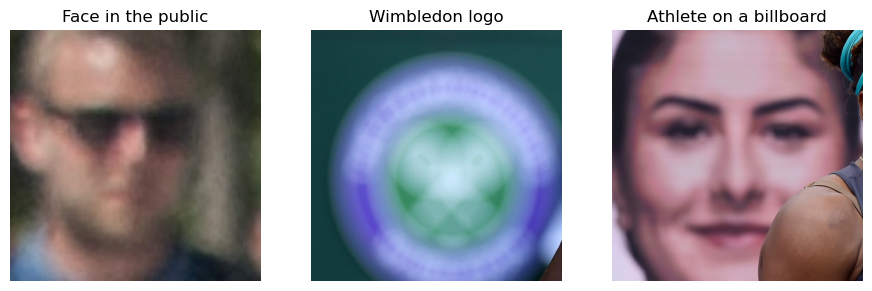

In [10]:
index_subplot = 0
plt.figure(figsize=(11, 11))
subtitles = ['Face in the public', 'Wimbledon logo', 'Athlete on a billboard']
for outlier_ex in os.scandir('./outliers_examples'):
    index_subplot += 1
    im_out = cv2.imread(outlier_ex.path)
    im_out = cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB)
    plt.subplot(1,3,index_subplot), plt.imshow(im_out)
    plt.title(subtitles[index_subplot-1])
    plt.axis('off')
plt.show()

Here's the kind of outlier generated: a viewer's face, a circular pattern, a face on a billboard.  

We manually get rid of these images, identifying their index in each folder.

In [11]:
outliers_index_serena = ['2_0','2_1','5_0','5_1','5_2','5_3','5_4','5_5','5_6','7_1','11_1','16_1','16_2','17_0','25_0','32_0','35_1','38_0','42_0','50_1','51_0','53_1','54_1','54_2','64_0','64_1']
outliers_index_roger = ['21_1','21_2','21_3','30_0','30_1','33_1','44_1','46_1']
outliers_index_virat = ['16_1','20_1','26_0','34_0','35_0','35_1','36_1','55_0','72_0','78_0','96_0','99_0']
outliers_index_lionel = ['5_1','5_2','6_0','24_0','24_1','33_1','33_2','34_1','38_0','38_1','38_2','38_3','55_1']
outliers_index_maria = ['2_1','26_2','26_3','31_0','31_2','39_0','39_1','39_2','41_1','48_1','62_0']

In [12]:
dict_outl = {
    'sw' :{
        'crop_folder_path':'./images_dataset/cropped/serena_williams',
        'outliers_index':['2_0','2_1','5_0','5_1','5_2','5_3','5_4','5_5','5_6','7_1','11_1','16_1','16_2','17_0','25_0','32_0','35_1','38_0','42_0','50_1','51_0','53_1','54_1','54_2','64_0','64_1'],
        'target_label':1
    }, 
    'rf' :{
        'crop_folder_path':'./images_dataset/cropped/roger_federer',
        'outliers_index':['21_1','21_2','21_3','30_0','30_1','33_1','44_1','46_1'],
        'target_label':2
    },
    'vk' :{
        'crop_folder_path':'./images_dataset/cropped/virat_kohli',
        'outliers_index':['16_1','20_1','26_0','34_0','35_0','35_1','36_1','55_0','72_0','78_0','96_0','99_0'],
        'target_label':3
    },
    'lm' :{
        'crop_folder_path':'./images_dataset/cropped/lionel_messi',
        'outliers_index':['5_1','5_2','6_0','24_0','24_1','33_1','33_2','34_1','38_0','38_1','38_2','38_3','55_1'],
        'target_label':4
    },
    'ms' :{
        'crop_folder_path':'./images_dataset/cropped/maria_sharapova',
        'outliers_index':['2_1','26_2','26_3','31_0','31_2','39_0','39_1','39_2','41_1','48_1','62_0'],
        'target_label':5
    }
}
    

In [13]:
for athlete, dict_params in dict_outl.items():
    for index in dict_params['outliers_index']:
        os.remove(dict_params['crop_folder_path']+'/'+index+'.jpg')

<h1 style="color:blue; font-weight:bold;"> Feature Engineering </h1>

In addition to attempting to classify raw images directly, we will try to train our models on other image transforms.

<h2 style="color:orange; font-weight:bold;"> Wavelet Transform </h2>

The wavelet transform decomposes an image into several levels of detail and resolution for multi-resolution analysis.

In [14]:
def wavelet_transform(image, mode='haar', level=1):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.float32(gray)
    gray = gray/255
    coeffs_wt = pywt.wavedec2(gray, mode, level = level)
    coeffs_h = list(coeffs_wt)
    coeffs_h[0] = coeffs_h[0]*0
    gray_h = pywt.waverec2(coeffs_h, mode)
    gray_h = gray_h*255
    gray_h = np.uint8(gray_h)
    return gray_h

<h2 style="color:orange; font-weight:bold;"> Local Binary Pattern Transform </h2>

The local binary transform (LBP) encodes texture patterns by comparing neighboring pixels to a central pixel, producing a binary signature of the texture.

In [15]:
from skimage.feature import local_binary_pattern

def lbp_transform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    radius = 1 
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    return lbp

<h2 style="color:orange; font-weight:bold;"> Scale Invariant Feature Transform </h2>

The SIFT (Scale-Invariant Feature Transform) detects and describes local features that are robust to changes in scale and rotation.

In [16]:
def sift_transform(image, N=102): # Padding with 0 ; the 102 value corresponds to the 3rd quantile of the sizes of all sift transform
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros((1, 128))
    if len(descriptors) > N:
        return descriptors[:N]
    else:
        padded_descriptors = np.zeros((N, 128))
        padded_descriptors[:len(descriptors), :] = descriptors
        return padded_descriptors


<h2 style="color:orange; font-weight:bold;"> Histogram of Oriented Gradients Transform </h2>

The HoG (Histogram of Oriented Gradients) transform extracts oriented gradient features in local cells for object detection.

In [17]:
def hog_transform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hog = cv2.HOGDescriptor()
    hog_features = hog.compute(gray)
    return hog_features

In [18]:
X_raw=[]
X_wav=[]
X_lbp=[]
X_hog=[]
X_sift=[]
y=[]
for _, dict_params in dict_outl.items():
    for file in os.scandir(dict_params['crop_folder_path']):
        raw_image = cv2.imread(file.path)
        scaled_raw = cv2.resize(raw_image, (128,128))
        scaled_raw = cv2.cvtColor(scaled_raw, cv2.COLOR_BGR2RGB)
        img_har =  wavelet_transform(scaled_raw, 'db1', 5)
        img_lbp = lbp_transform(scaled_raw)
        img_hog = hog_transform(scaled_raw)
        img_sift = sift_transform(scaled_raw, N=102)
        X_raw.append(scaled_raw)
        X_wav.append(img_har)
        X_lbp.append(img_lbp)
        X_hog.append(img_hog)
        X_sift.append(img_sift)
        y.append(dict_params['target_label'])

It's not easy to visualize the HoG transform because it doesn't correspond directly to an image. Here's a code to represent it (found on stackoverflow.com).

In [21]:
from skimage import exposure
from skimage.feature import hog
## Found on stackoverflow
def display_hog(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    
    hog_features, hog_image = hog(
        gray_image, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        block_norm='L2-Hys', 
        visualize=True, 
        feature_vector=True,
        orientations=9
    )
    
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    plt.axis('off')
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title('HoG transform')

(-0.5, 255.5, 255.5, -0.5)

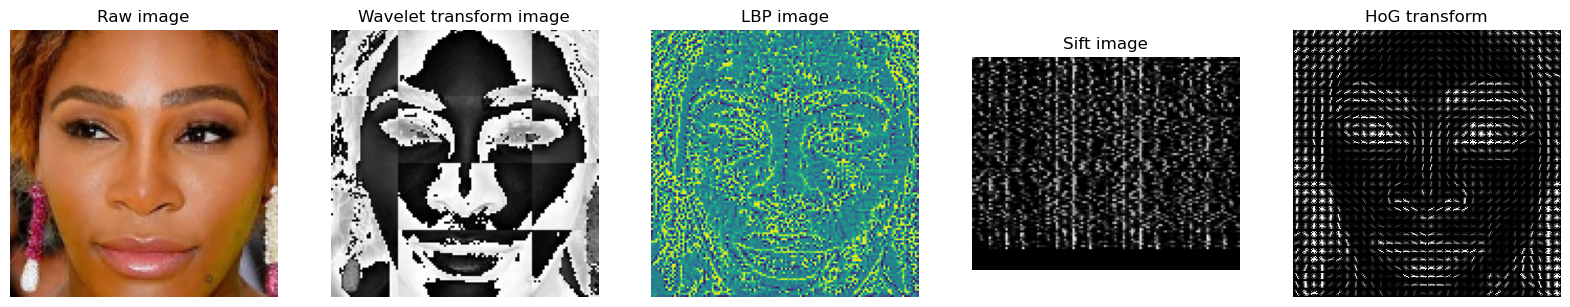

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(1,5,1),plt.imshow(X_raw[0])
plt.axis('off')
plt.title('Raw image')
plt.subplot(1,5,2),plt.imshow(X_wav[0], cmap = 'gray')
plt.axis('off')
plt.title('Wavelet transform image')
plt.subplot(1,5,3),plt.imshow(X_lbp[0])
plt.axis('off')
plt.title('LBP image')
plt.subplot(1,5,4),plt.imshow(X_sift[0], cmap = 'gray')
plt.axis('off')
plt.title('Sift image')
plt.subplot(1,5,5),display_hog('./useful_images_in_notebook/williams.jpg')
plt.axis('off')

Before classification, images are converted to vectors and then normalized.

In [23]:
X_raw = [(image.flatten() - image.min())/(image.max()-image.min()) for image in X_raw]
X_wav = [(image.flatten() - image.min())/(image.max()-image.min()) for image in X_wav]
X_lbp = [(image.flatten() - image.min())/(image.max()-image.min()) for image in X_lbp]
X_sift = [(image.flatten() - image.min())/(image.max()-image.min()) for image in X_sift]
X_hog = [(image.flatten() - image.min())/(image.max()-image.min()) for image in X_hog]

<h1 style="color:blue; font-weight:bold;"> Model Conception </h1>

Here, we will compare several models: CVS, Random Forest, Logistic Regression and KNN. The optimal hyperparameters for each of these models will be determined using GridSearchCV.

The models will be trained for each of the different transforms, to determine which is best for training. 

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
parameters={
    'svm':{
        'model':SVC(),
        'params':{
            'C':[1,5,10],
            'kernel':['rbf','linear'],
            'gamma':['scale','auto']
        }
    },
    'rf':{
        'model':RandomForestClassifier(),
        'params':{
            'n_estimators':[100,1000],
            'criterion':['gini','entropy']
        }
    },
    'lr':{
        'model':LogisticRegression(max_iter=1000, solver='liblinear'),
        'params':{
            'fit_intercept':[True,False],
            'penalty':['l1', 'l2'] 
        }
    },
    'knn':{
        'model':KNeighborsClassifier(),
        'params':{
            'n_neighbors':[3,5,7,10],
            'weights':['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        }
    }
}                         

<h2 style="color:orange; font-weight:bold;"> Raw images </h2>

In [26]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=11)
for model_name, model_params in parameters.items():
    gscv = GridSearchCV(model_params['model'], model_params['params'], cv = 5, verbose = 1, n_jobs = -1)
    gscv.fit(X_train, y_train)
    print(f'The best validation accuracy for {model_name} is {gscv.best_score_}, achieved with the following parameters: {gscv.best_params_} \n')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best validation accuracy for svm is 0.837087087087087, achieved with the following parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for rf is 0.81006006006006, achieved with the following parameters: {'criterion': 'entropy', 'n_estimators': 100} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for lr is 0.853003003003003, achieved with the following parameters: {'fit_intercept': True, 'penalty': 'l2'} 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best validation accuracy for knn is 0.707057057057057, achieved with the following parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'} 

CPU times: user 56.7 s, sys: 1min 15s, total: 2min 12s
Wall time: 4min 27s


<h2 style="color:orange; font-weight:bold;"> Wavelet Transformed images </h2>

In [27]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_wav, y, test_size=0.2, random_state=11)
for model_name, model_params in parameters.items():
    gscv = GridSearchCV(model_params['model'], model_params['params'], cv = 5, verbose = 1, n_jobs = -1)
    gscv.fit(X_train, y_train)
    print(f'The best validation accuracy for {model_name} is {gscv.best_score_}, achieved with the following parameters: {gscv.best_params_} \n')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best validation accuracy for svm is 0.7878378378378378, achieved with the following parameters: {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for rf is 0.7933933933933934, achieved with the following parameters: {'criterion': 'entropy', 'n_estimators': 1000} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for lr is 0.7495495495495496, achieved with the following parameters: {'fit_intercept': True, 'penalty': 'l2'} 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best validation accuracy for knn is 0.5548048048048048, achieved with the following parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'} 

CPU times: user 41.1 s, sys: 18.8 s, total: 60 s
Wall time: 1min 58s


<h2 style="color:orange; font-weight:bold;"> LBP images </h2>

In [28]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_lbp, y, test_size=0.2, random_state=11)
for model_name, model_params in parameters.items():
    gscv = GridSearchCV(model_params['model'], model_params['params'], cv = 5, verbose = 1, n_jobs = -1)
    gscv.fit(X_train, y_train)
    print(f'The best validation accuracy for {model_name} is {gscv.best_score_}, achieved with the following parameters: {gscv.best_params_} \n')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best validation accuracy for svm is 0.2993993993993994, achieved with the following parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for rf is 0.37477477477477483, achieved with the following parameters: {'criterion': 'entropy', 'n_estimators': 100} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for lr is 0.3370870870870871, achieved with the following parameters: {'fit_intercept': True, 'penalty': 'l2'} 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best validation accuracy for knn is 0.25, achieved with the following parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'} 

CPU times: user 17.8 s, sys: 13.2 s, total: 31 s
Wall time: 1min 12s


<h2 style="color:orange; font-weight:bold;"> Sift images </h2>

In [29]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_sift, y, test_size=0.2, random_state=11)
for model_name, model_params in parameters.items():
    gscv = GridSearchCV(model_params['model'], model_params['params'], cv = 5, verbose = 1, n_jobs = -1)
    gscv.fit(X_train, y_train)
    print(f'The best validation accuracy for {model_name} is {gscv.best_score_}, achieved with the following parameters: {gscv.best_params_} \n')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best validation accuracy for svm is 0.44624624624624626, achieved with the following parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for rf is 0.3588588588588589, achieved with the following parameters: {'criterion': 'entropy', 'n_estimators': 1000} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for lr is 0.4406906906906907, achieved with the following parameters: {'fit_intercept': True, 'penalty': 'l2'} 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best validation accuracy for knn is 0.3097597597597598, achieved with the following parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'} 

CPU times: user 27.2 s, sys: 9.4 s, total: 36.6 s
Wall time: 1min 8s


<h2 style="color:orange; font-weight:bold;"> HoG Transformed images </h2>

In [30]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=11)
for model_name, model_params in parameters.items():
    gscv = GridSearchCV(model_params['model'], model_params['params'], cv = 5, verbose = 1, n_jobs = -1)
    gscv.fit(X_train, y_train)
    print(f'The best validation accuracy for {model_name} is {gscv.best_score_}, achieved with the following parameters: {gscv.best_params_} \n')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best validation accuracy for svm is 0.8968468468468469, achieved with the following parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for rf is 0.820870870870871, achieved with the following parameters: {'criterion': 'entropy', 'n_estimators': 1000} 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best validation accuracy for lr is 0.9240240240240241, achieved with the following parameters: {'fit_intercept': True, 'penalty': 'l2'} 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
The best validation accuracy for knn is 0.7117117117117117, achieved with the following parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'} 

CPU times: user 41.4 s, sys: 22.2 s, total: 1min 3s
Wall time: 2min 16s


Finally, the best training is performed on HoG transformed images. We notice that the SVC and Logistic Regression models achieve validation accuracies very close to each other.
To decide between them, we will calculate the test accuracy.

In [31]:
lr = LogisticRegression(fit_intercept= True, penalty= 'l2')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8936170212765957

In [32]:
svm = SVC(C=1, gamma='scale', kernel= 'linear', probability=True)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.9148936170212766

The best test accuracy is achieved for SVM. Thus, we will save this model.

<h1 style="color:blue; font-weight:bold;"> Athlete Classification </h1>

To classify new images, it is necessary to reproduce all the pre-processing carried out upstream. That is what the 'predict_image' function does. 
Since the process is fully automated, there's no need for manual removing outliers.

To compensate for this, if several faces are detected, the function returns the prediction whose model is the "safest", thanks to the 'predict_proba' method. However, these cases are more prone to error.

In [33]:
import joblib  
joblib.dump(svm, 'model_classification.pkl')

['model_classification.pkl']

In [34]:
loaded_model = joblib.load('model_classification.pkl')

In [43]:
def predict_image(path_image):
    classes = ['Serena Williams','Roger Federer','Virat Kohli','Lionel Messi','Maria Sharapova']
    img_to_predict = cv2.imread(path_image)
    gray_img_to_predict = cv2.cvtColor(img_to_predict, cv2.COLOR_BGR2GRAY)
    rgb_img_to_predict = cv2.cvtColor(img_to_predict, cv2.COLOR_BGR2RGB)
    cropped_img_to_predict = crop_faces_from_full_image(img_to_predict)
    if cropped_img_to_predict is None:
        print('Unfortunately, no face was detected in the provided image.')
        plt.imshow(rgb_img_to_predict)
        plt.axis('off')
        return
    elif len(cropped_img_to_predict) == 1:
        cropped_img_to_predict_rescaled = cv2.resize(cropped_img_to_predict[0], (128,128))
        hog_to_predict = hog_transform(cropped_img_to_predict_rescaled)
        hog_to_predict_normalized = (hog_to_predict.flatten() - hog_to_predict.min())/(hog_to_predict.max()-hog_to_predict.min())
        target = loaded_model.predict(hog_to_predict_normalized.reshape(1, -1))
        proba = loaded_model.predict_proba(hog_to_predict_normalized.reshape(1, -1))
    else:
        print('Several faces were detected in the image. The classification may have been distorted by these other faces.')
        proba_tmp = 0
        for cropped_face in cropped_img_to_predict:
            cropped_face_rescaled = cv2.resize(cropped_face, (128,128))
            hog_to_predict = hog_transform(cropped_face_rescaled)
            hog_to_predict_normalized = (hog_to_predict.flatten() - hog_to_predict.min())/(hog_to_predict.max()-hog_to_predict.min())
            proba = loaded_model.predict_proba(hog_to_predict.reshape(1, -1))
            if np.max(proba[0]) > proba_tmp:
                target = loaded_model.predict(hog_to_predict_normalized.reshape(1, -1))
    plt.imshow(rgb_img_to_predict)
    plt.axis('off')
    print(f'The person detected is {classes[target[0]-1]} (confidence = {round(np.max(proba[0]), 2)})')


The person detected is Maria Sharapova (confidence = 0.9)


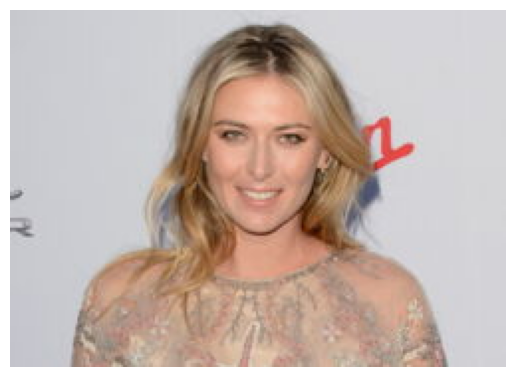

In [44]:
predict_image('./test_images/maria-sharapova.jpg')

Several faces were detected in the image. The classification may have been distorted by these other faces.
The person detected is Serena Williams (confidence = 0.53)


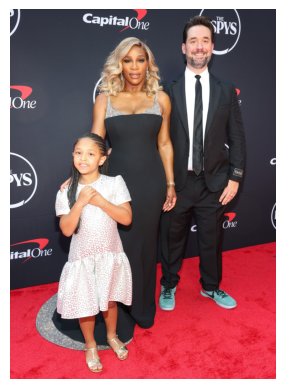

In [45]:
predict_image('./test_images/serena-williams.jpg')

The person detected is Virat Kohli (confidence = 0.92)


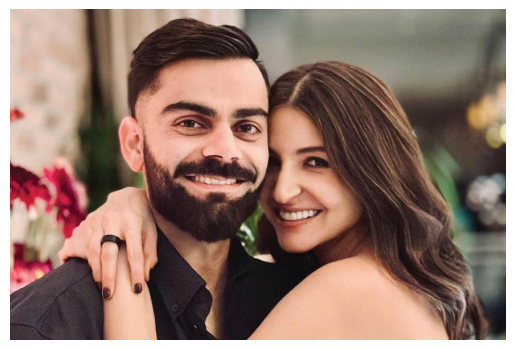

In [46]:
predict_image('./test_images/virat-kohli.jpg')

Unfortunately, no face was detected in the provided image.


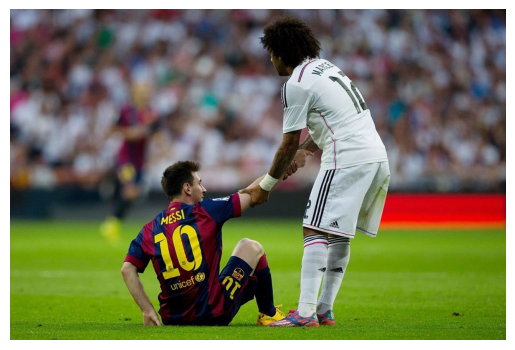

In [47]:
predict_image('./test_images/lionel-messi.jpg')

Several faces were detected in the image. The classification may have been distorted by these other faces.
The person detected is Roger Federer (confidence = 0.35)


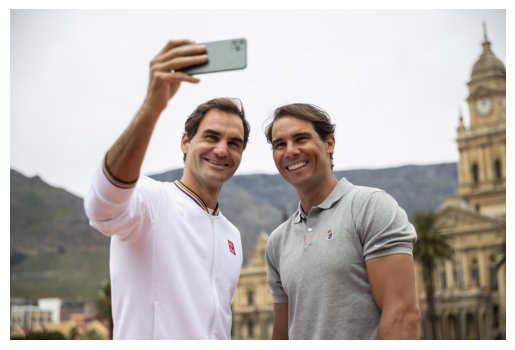

In [48]:
predict_image('./test_images/roger-federer.jpg')